In [1]:
import botorch
import gpytorch
import matplotlib.pyplot as plt
import torch

from bo.models import BotorchGPModel
from bo.objectives import forrester_1d
from bo.plots import visualize_gp_belief_and_policy
from bo.train import fit_gp_model

In [2]:
bound = 5

xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(2)
train_x = torch.rand(size=(1, 1)) * 2 * bound - bound
train_y = forrester_1d(train_x)

In [3]:
train_x = torch.tensor([[1.0], [2.0]])
train_y = forrester_1d(train_x)

print(torch.hstack([train_x, train_y.unsqueeze(1)]))

tensor([[1.0000, 1.6054],
        [2.0000, 1.5029]])


iteration 0
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

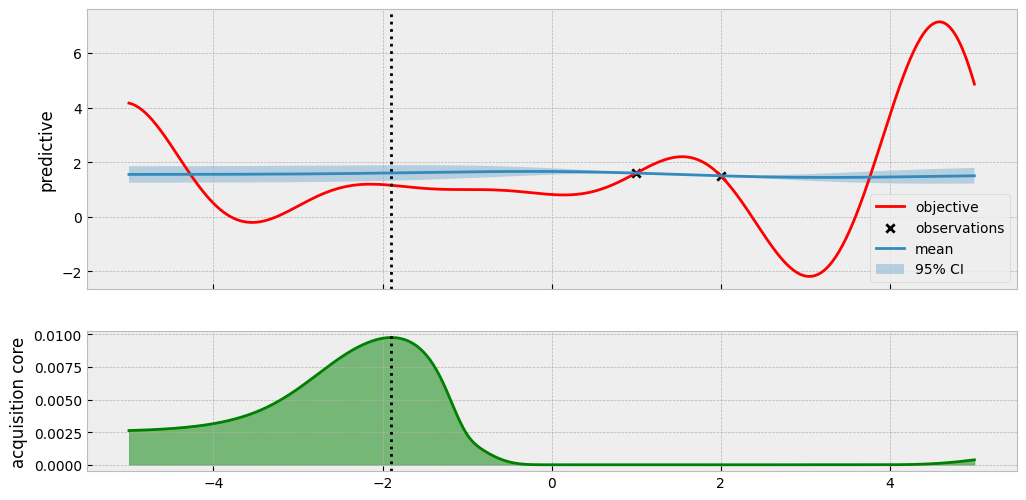

iteration 1
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

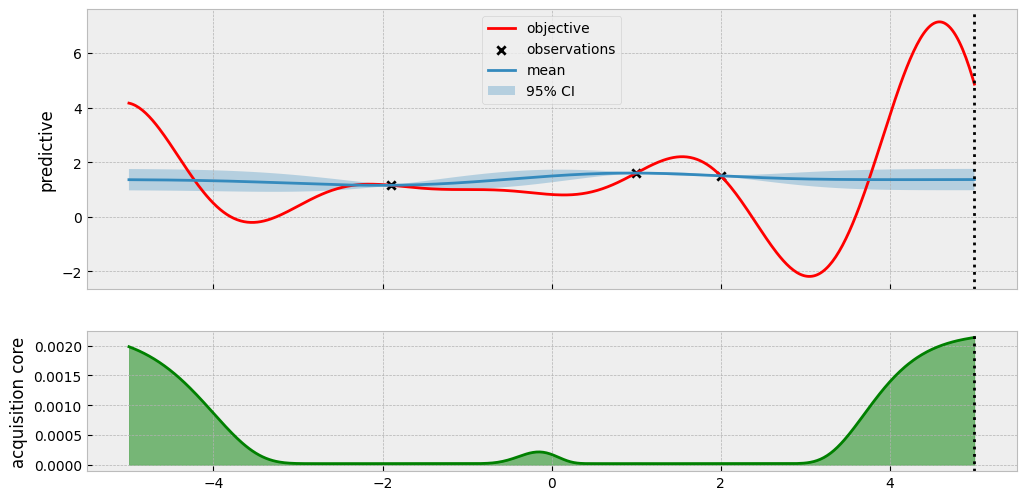

iteration 2
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

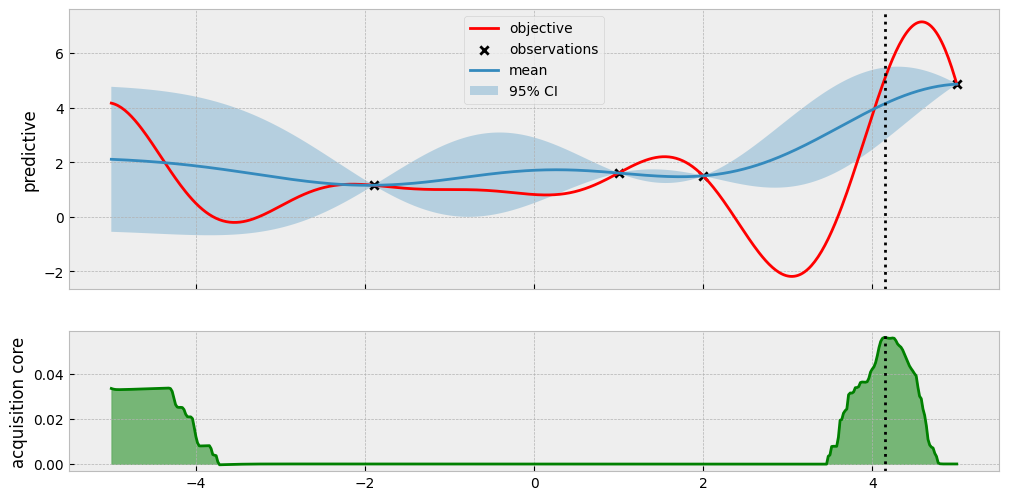

iteration 3
incumbent tensor([4.1464]) tensor(5.0420)


  0%|          | 0/500 [00:00<?, ?it/s]

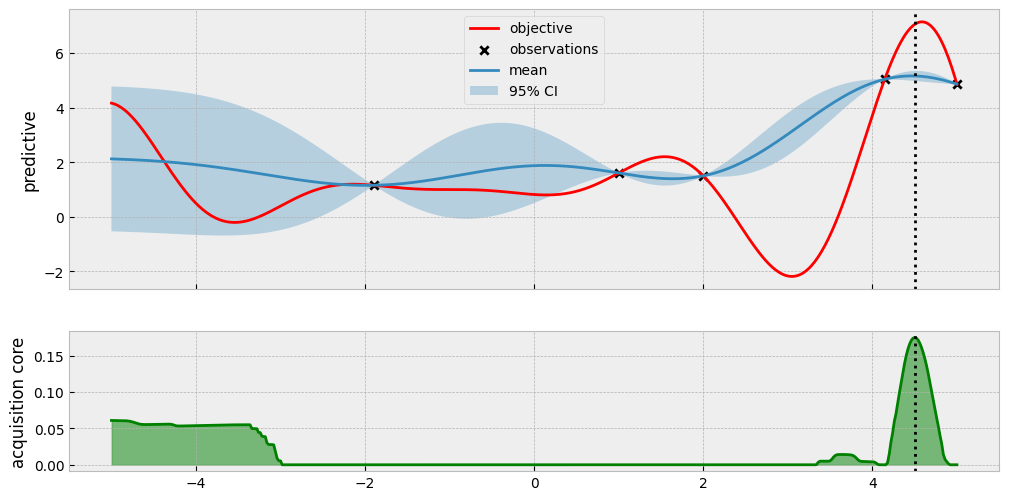

iteration 4
incumbent tensor([4.5019]) tensor(7.0541)


  0%|          | 0/500 [00:00<?, ?it/s]

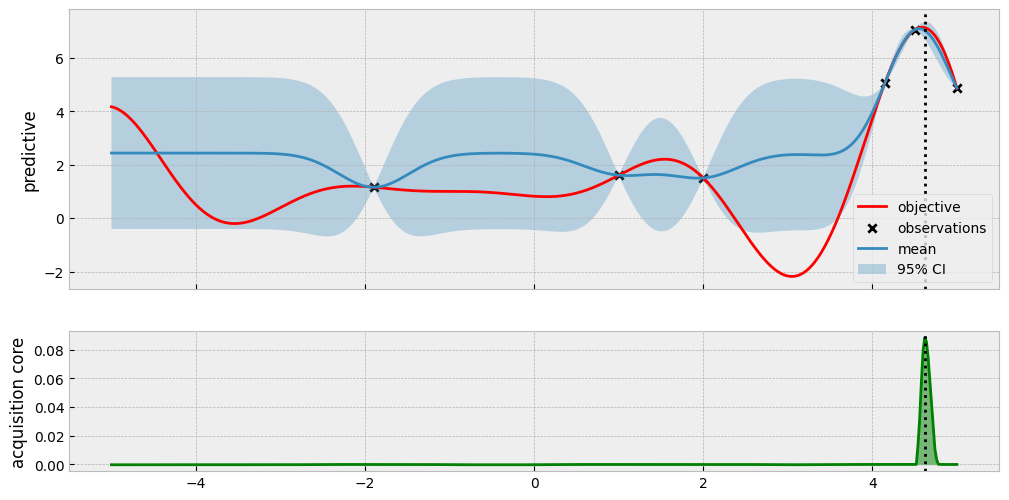

iteration 5
incumbent tensor([4.6247]) tensor(7.1247)


  0%|          | 0/500 [00:00<?, ?it/s]

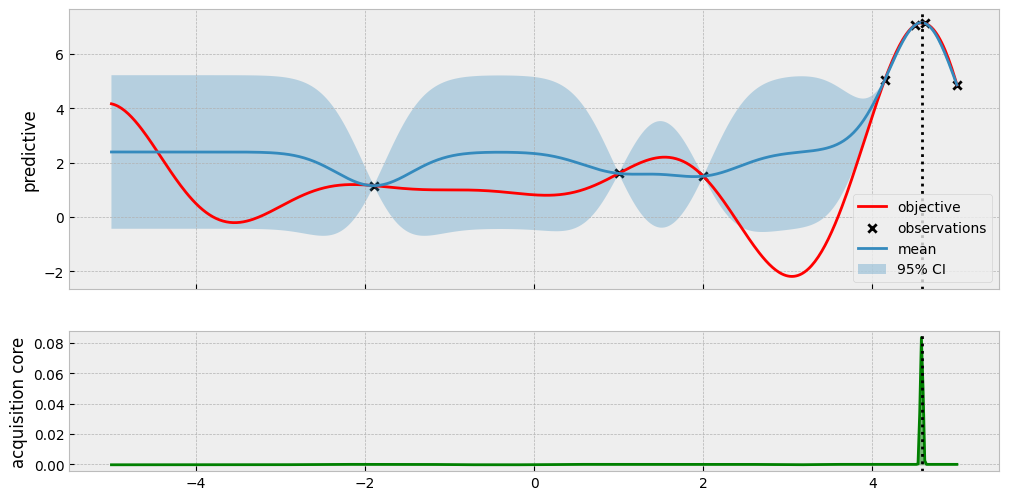

iteration 6
incumbent tensor([4.5819]) tensor(7.1436)


  0%|          | 0/500 [00:00<?, ?it/s]

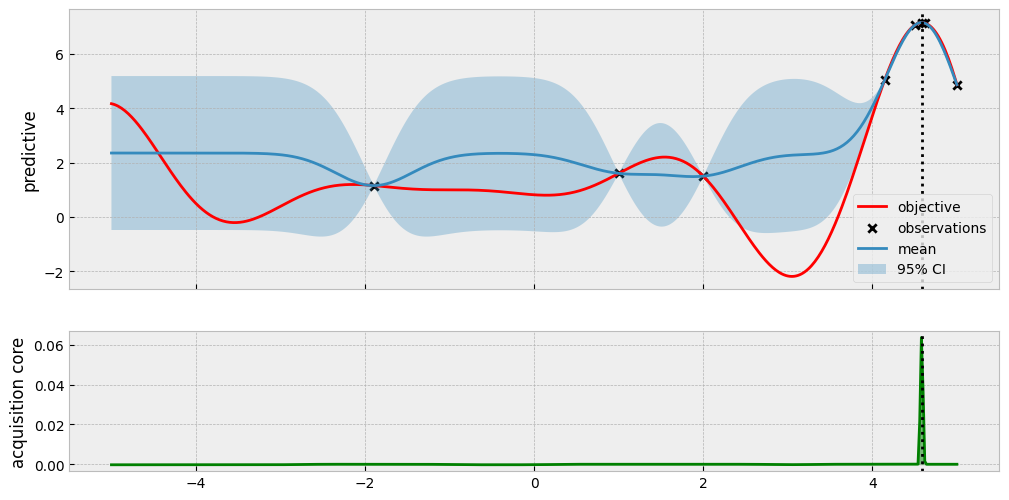

iteration 7
incumbent tensor([4.5839]) tensor(7.1437)


  0%|          | 0/500 [00:00<?, ?it/s]

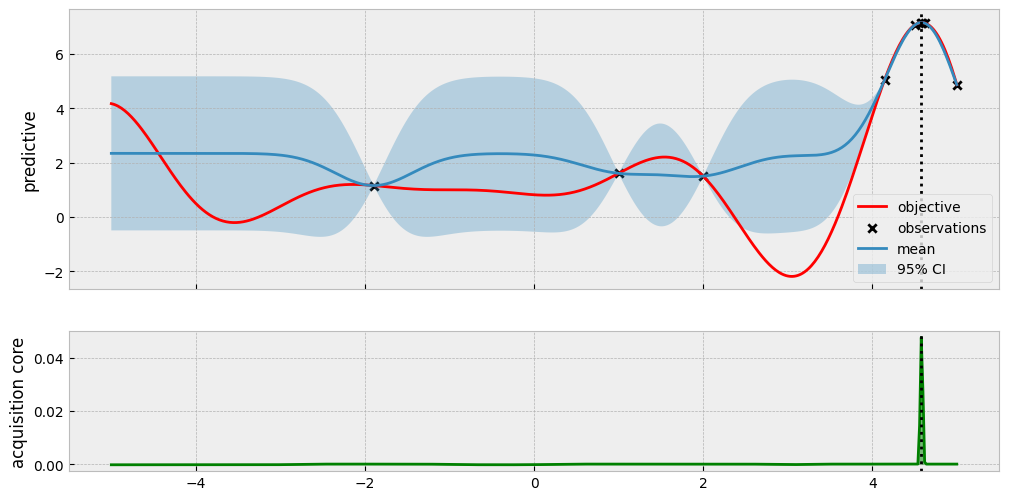

iteration 8
incumbent tensor([4.5839]) tensor(7.1437)


  0%|          | 0/500 [00:00<?, ?it/s]

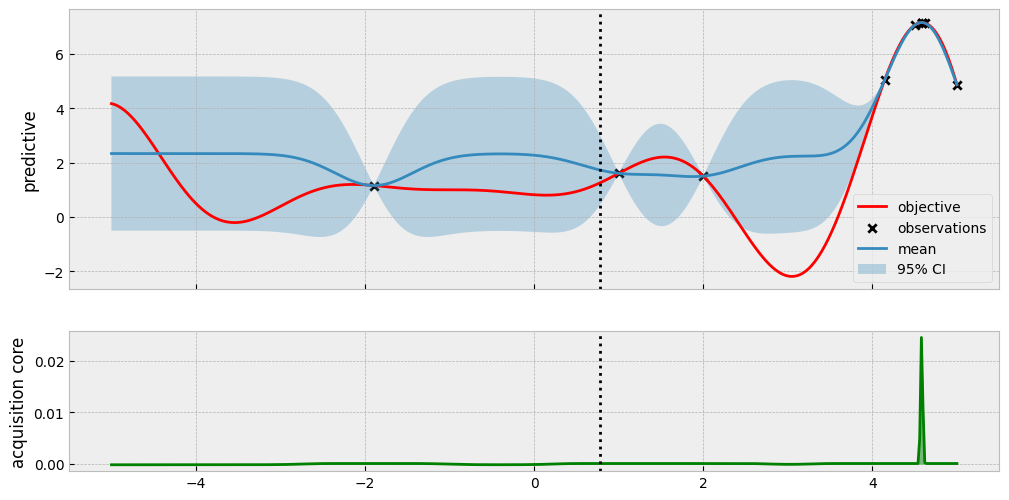

iteration 9
incumbent tensor([4.5839]) tensor(7.1437)


  0%|          | 0/500 [00:00<?, ?it/s]

/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-bayesian-optimization-in-action-aU6qUxK9-py3.12/lib/python3.12/site-packages/botorch/optim/optimize.py:652: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


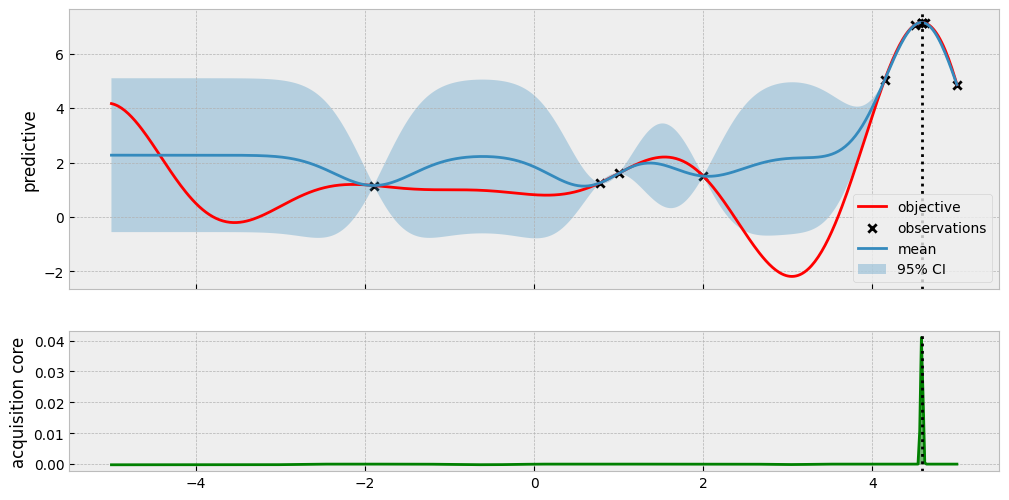

In [4]:
num_candidates = 1000
num_queries = 10


for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    sobol = torch.quasirandom.SobolEngine(1, scramble=True)
    candidate_x = sobol.draw(num_candidates)
    candidate_x = 10 * candidate_x - 5

    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = BotorchGPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise
    fit_gp_model(model, likelihood, train_x, train_y)

    policy = botorch.acquisition.max_value_entropy_search.qMaxValueEntropy(
        model, candidate_x
    )

    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    visualize_gp_belief_and_policy(
        model,
        likelihood,
        xs,
        ys,
        train_x,
        train_y,
        policy=policy,
        next_x=next_x,
    )
    plt.show()

    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])